In [18]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import pytensor.tensor as pt

sns.set_style("whitegrid")

In [2]:
raw_df = pd.read_csv("../data/huckleberry_14aug2024.csv", parse_dates=["Start", "End"])
raw_df.columns = [col.lower() for col in raw_df.columns]
raw_df["duration"] = raw_df["end"] - raw_df["start"]
raw_df["duration_minutes"] = raw_df["duration"].dt.seconds / 60
# Remove first and last days
raw_df = raw_df[(raw_df["start"].dt.date > datetime.date(2024, 7, 26)) & (raw_df["end"].dt.date < datetime.date(2024, 8, 14))]
raw_df = raw_df.sort_values("start")
raw_df

,type,start,end,duration,start condition,start location,end condition,notes,duration_minutes
547,Sleep,2024-07-27 00:00:00,2024-07-27 00:11:00,0 days 00:11:00,NaN,NaN,NaN,NaN,11.0
546,Feed,2024-07-27 00:22:00,2024-07-27 00:31:00,0 days 00:09:00,00:00R,Breast,00:08L,NaN,9.0
544,Feed,2024-07-27 00:49:00,2024-07-27 01:07:00,0 days 00:18:00,Null r,Breast,00:18L,NaN,18.0
543,Feed,2024-07-27 01:17:00,2024-07-27 01:27:00,0 days 00:10:00,00:10R,Breast,Null l,NaN,10.0
542,Sleep,2024-07-27 01:43:00,2024-07-27 02:06:00,0 days 00:23:00,NaN,NaN,NaN,NaN,23.0
...,...,...,...,...,...,...,...,...,...
15,Feed,2024-08-13 15:25:00,2024-08-13 16:08:00,0 days 00:43:00,00:12R,Breast,00:29L,NaN,43.0
13,Sleep,2024-08-13 17:13:00,2024-08-13 18:42:00,0 days 01:29:00,NaN,NaN,NaN,NaN,89.0
12,Feed,2024-08-13 18:56:00,2024-08-13 19:28:00,0 days 00:32:00,00:31R,Breast,Null l,NaN,32.0
10,Feed,2024-08-13 20:53:00,2024-08-13 21:20:00,0 days 00:27:00,Null r,Breast,00:27L,NaN,27.0


In [3]:
raw_df["start_date"] = raw_df["start"].dt.date
raw_df["start_time"] = raw_df["start"].dt.time
raw_df["end_date"] = raw_df["end"].dt.date
raw_df["end_time"] = raw_df["end"].dt.time

In [4]:
raw_df["start_date"].nunique()

18

In [10]:
sdf = raw_df.query("type=='Sleep'").copy()

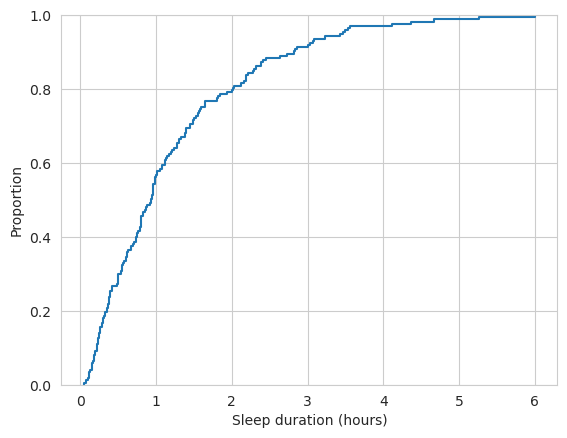

In [11]:
ax = sns.ecdfplot(sdf["duration"].dt.seconds / 60 / 60)
ax.set_xlabel("Sleep duration (hours)");

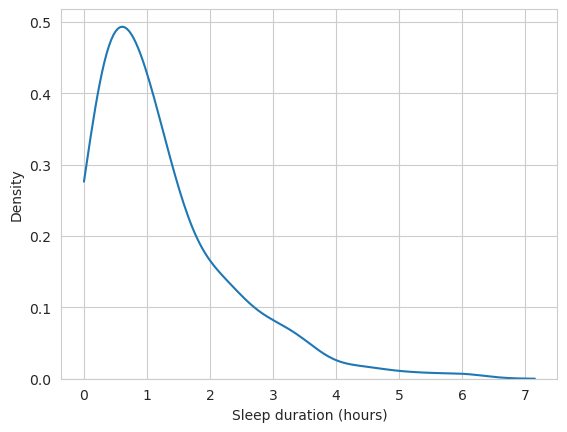

In [12]:
ax = sns.kdeplot((sdf["duration"].dt.seconds / 60 / 60), clip=(0, None))
ax.set_xlabel("Sleep duration (hours)");

In [13]:
sdf.loc[:, "prev_end"] = sdf["end"].shift()
sdf.loc[:, "sleep_gap"] = sdf["start"] - sdf["prev_end"]

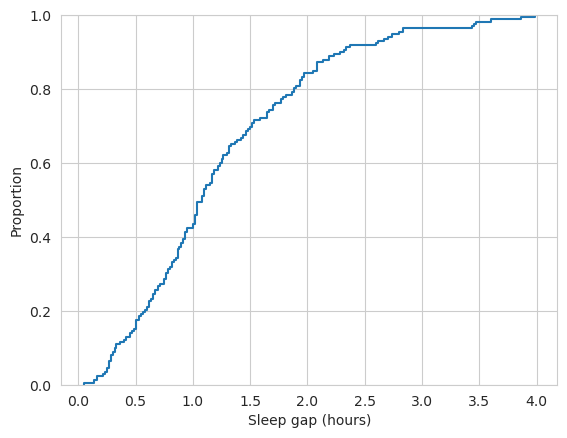

In [14]:
ax = sns.ecdfplot(sdf["sleep_gap"].dt.seconds / 60 / 60)
ax.set_xlabel("Sleep gap (hours)");

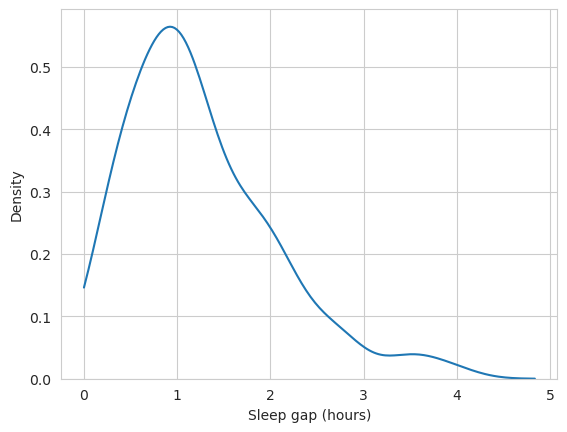

In [16]:
ax = sns.kdeplot((sdf["sleep_gap"].dt.seconds / 60 / 60), clip=(0, None))
ax.set_xlabel("Sleep gap (hours)");

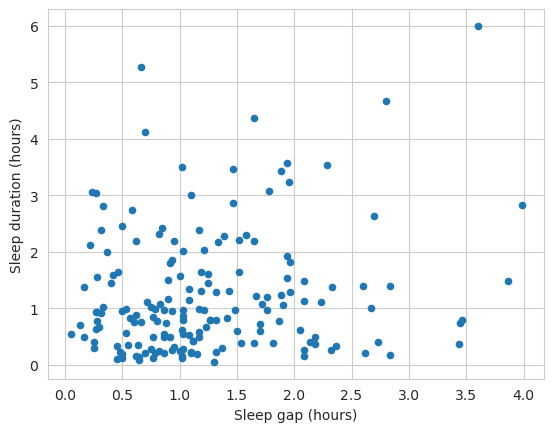

In [17]:
plt.scatter(sdf["sleep_gap"].dt.seconds / 60 / 60, sdf["duration"].dt.seconds / 60 / 60, s=20)
plt.xlabel("Sleep gap (hours)")
plt.ylabel("Sleep duration (hours)");

## Exponential survival model

In [25]:
sleep_gap = (sdf["sleep_gap"].dt.seconds / 60 / 60).dropna().values

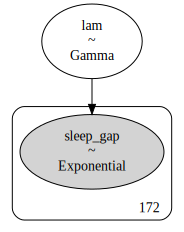

In [46]:
with pm.Model() as exp_model:
    lam = pm.Gamma("lam", mu=1, sigma=.05)
    gap = pm.Exponential("sleep_gap", scale=lam, observed=sleep_gap)

exp_model.to_graphviz()

Sampling: [lam, sleep_gap]


<Axes: >

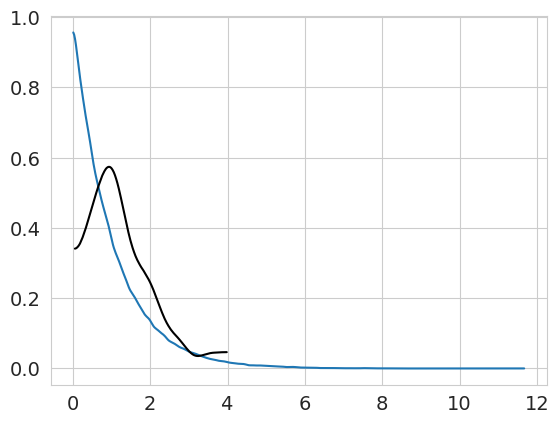

In [52]:
with exp_model:
    exp_idata = pm.sample_prior_predictive()

pm.plots.plot_dist(exp_idata.prior_predictive["sleep_gap"])
pm.plots.plot_dist(sleep_gap, color="k")

In [53]:
with exp_model:
    exp_idata_post = pm.sample()
    exp_idata.extend(exp_idata_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam]


/home/evelin/miniconda3/envs/making-sense-of-the-empada/lib/python3.12/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>]],
      dtype=object)

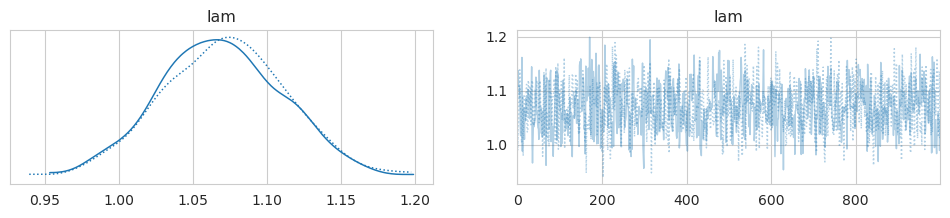

In [54]:
pm.plots.plot_trace(exp_idata);

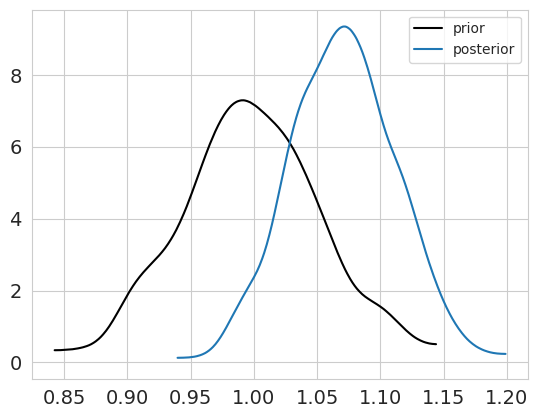

In [59]:
ax = pm.plots.plot_dist(exp_idata.prior["lam"], color="k", label="prior")
ax = pm.plots.plot_dist(exp_idata.posterior["lam"], ax=ax, label="posterior")

In [233]:
time = np.linspace(0, 12, 20)

with pm.Model(coords={"time": time}) as pred_model:
    lam = pm.Flat("lam")
    survival = pm.Deterministic(
        "survival",
        pt.exp(pm.logcdf(pm.Exponential.dist(scale=lam), time)),
        dims="time",
    )
    pred = pm.compute_deterministics(exp_idata.posterior)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

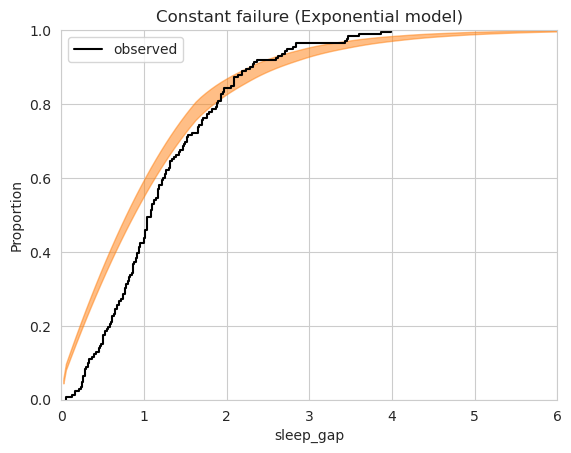

In [234]:
pm.plots.plot_hdi(pred["survival"].time, pred["survival"])
ax = sns.ecdfplot(sdf["sleep_gap"].dt.seconds / 60 / 60, color="k", label="observed")
ax.set_title("Constant failure (Exponential model)")
ax.set_xlim(0, 6)
plt.legend();

In [236]:
time = np.linspace(0, 12, 12*2+1)
test_t = [0, 1, 2, 3]
with pm.Model(coords={"time": time, "time2": time}) as pred_model:
    lam = pm.Flat("lam")
    for t in test_t:
        pm.Deterministic(
            f"conditional_survival_{t}",
            pt.exp(pm.logcdf(pm.Truncated.dist(pm.Exponential.dist(scale=lam), lower=t+1e-8), time)),
            dims=("time"),
        )
    
    pred = pm.compute_deterministics(exp_idata.posterior)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

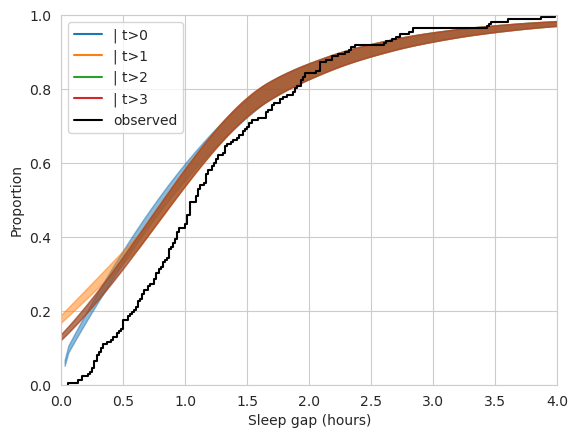

In [255]:
for i, t in enumerate(test_t):
    c = f"C{i}"
    ax = pm.plots.plot_hdi(pred.time - t, pred[f"conditional_survival_{t}"], color=c)
    ax.plot([], color=c, label=f"| t>{t}")
ax = sns.ecdfplot(sdf["sleep_gap"].dt.seconds / 60 / 60, color="k", label="observed")
# ax.set_title("Accelerated failure (Weibull model)")
ax.set_xlabel("Sleep gap (hours)")
ax.set_ylim(0, 1)
ax.set_xlim(0, 4)
plt.legend();

## Weibull accelerated model

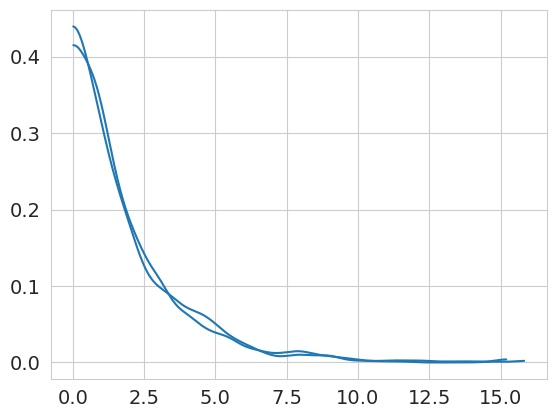

In [127]:
pm.plots.plot_dist(pm.draw(pm.Truncated.dist(pm.Exponential.dist(scale=2), lower=2, shape=(1000))) - 2)
pm.plots.plot_dist(pm.draw(pm.Exponential.dist(scale=2, shape=(1000))));

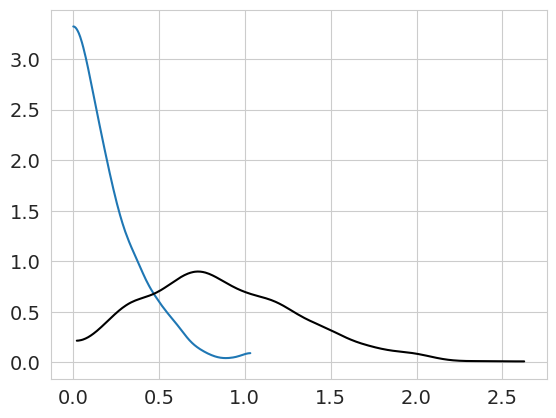

In [128]:
pm.plots.plot_dist(pm.draw(pm.Truncated.dist(pm.Weibull.dist(alpha=2, beta=1), lower=2, shape=(1000))) - 2)
pm.plots.plot_dist(pm.draw(pm.Weibull.dist(alpha=2, beta=1, shape=(1000))), color="k");

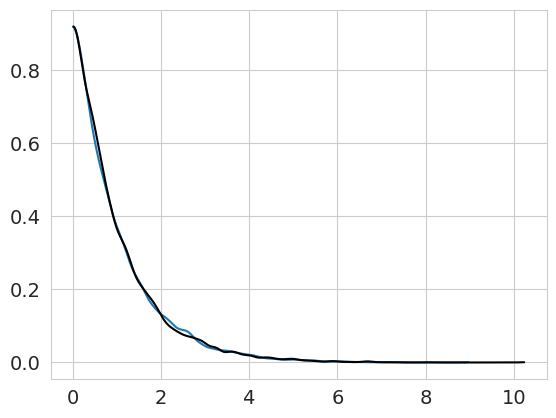

In [129]:
pm.plots.plot_dist(pm.draw(pm.Truncated.dist(pm.Weibull.dist(alpha=1, beta=1), lower=2, shape=(10000))) - 2)
pm.plots.plot_dist(pm.draw(pm.Weibull.dist(alpha=1, beta=1, shape=(10000))), color="k");

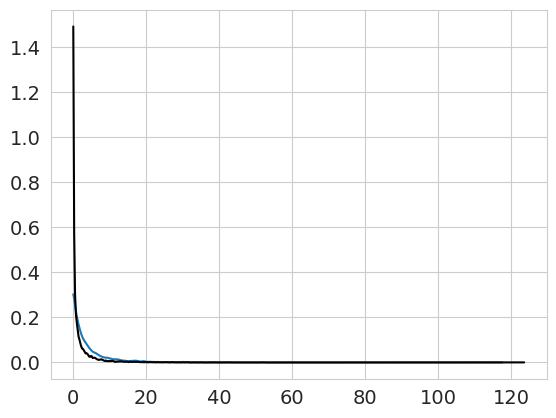

In [130]:
pm.plots.plot_dist(pm.draw(pm.Truncated.dist(pm.Weibull.dist(alpha=.5, beta=1), lower=2, shape=(10000))) - 2)
pm.plots.plot_dist(pm.draw(pm.Weibull.dist(alpha=.5, beta=1, shape=(10000))), color="k");

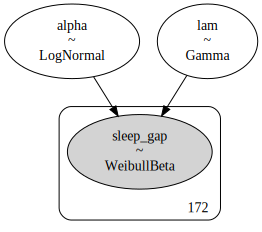

In [109]:
with pm.Model() as weibull_model:
    lam = pm.Gamma("lam", mu=1, sigma=.05)
    alpha = pm.LogNormal("alpha", 0, sigma=0.1)
    gap = pm.Weibull("sleep_gap", alpha=alpha, beta=lam, observed=sleep_gap)

weibull_model.to_graphviz()

Sampling: [alpha, lam, sleep_gap]


<Axes: >

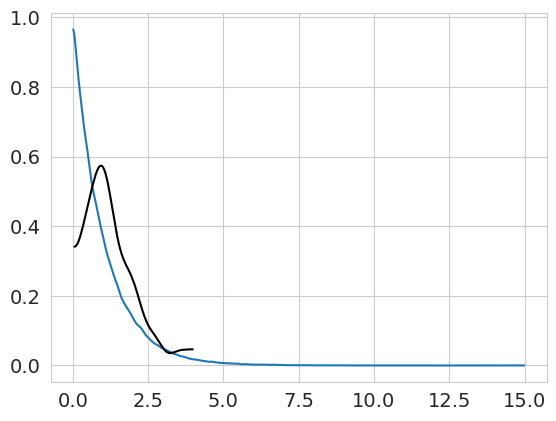

In [110]:
with weibull_model:
    weibull_idata = pm.sample_prior_predictive()

pm.plots.plot_dist(weibull_idata.prior_predictive["sleep_gap"])
pm.plots.plot_dist(sleep_gap, color="k")

In [111]:
with weibull_model:
    weibull_idata.extend(pm.sample())

Sampling 2 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:06

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


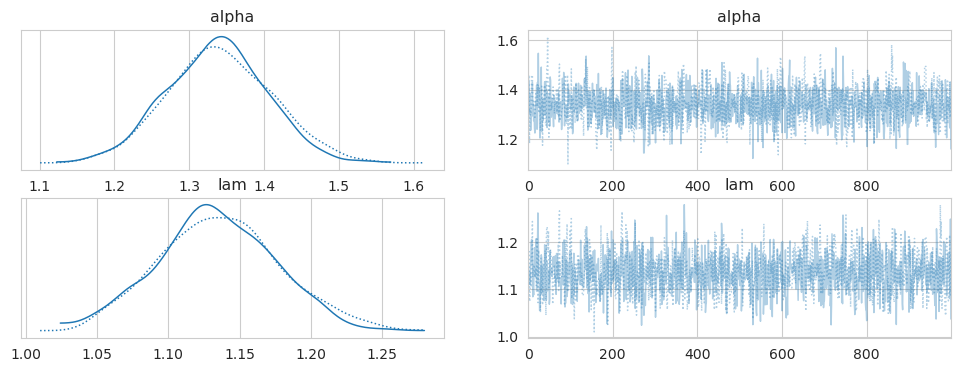

In [112]:
pm.plots.plot_trace(weibull_idata);

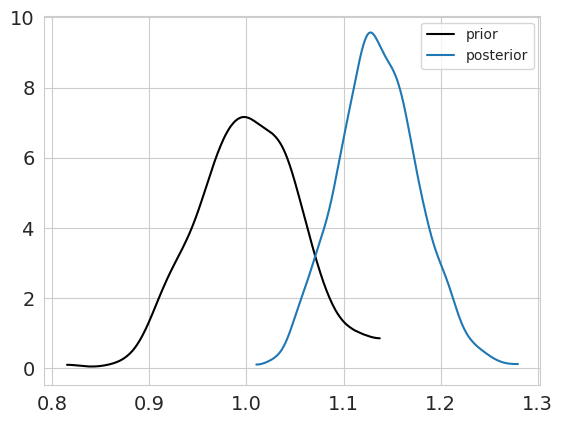

In [113]:
ax = pm.plots.plot_dist(weibull_idata.prior["lam"], color="k", label="prior")
ax = pm.plots.plot_dist(weibull_idata.posterior["lam"], ax=ax, label="posterior")

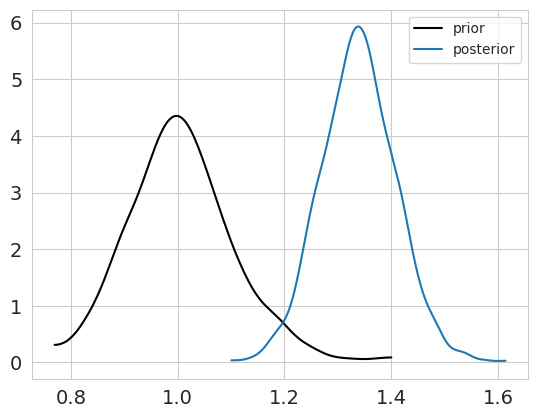

In [114]:
ax = pm.plots.plot_dist(weibull_idata.prior["alpha"], color="k", label="prior")
ax = pm.plots.plot_dist(weibull_idata.posterior["alpha"], ax=ax, label="posterior")

In [222]:
time = np.linspace(0, 12, 20)

with pm.Model(coords={"time": time}) as pred_model:
    lam = pm.Flat("lam")
    alpha = pm.Flat("alpha")
    pm.Deterministic(
        "survival",
        pt.exp(pm.logcdf(pm.Weibull.dist(alpha=alpha, beta=lam), time)),
        dims="time",
    )

    pm.Deterministic(
        "hazard",
        pt.exp(
            pm.logp(pm.Weibull.dist(alpha=alpha, beta=lam), time) 
            - pt.log1mexp(pm.logcdf(pm.Weibull.dist(alpha=alpha, beta=lam), time))
        ),
        dims="time",
    )
    
    pred = pm.compute_deterministics(weibull_idata.posterior)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

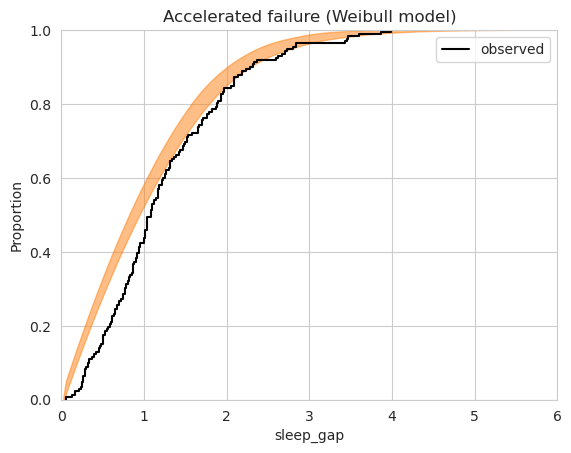

In [223]:
pm.plots.plot_hdi(pred["survival"].time, pred["survival"])
ax = sns.ecdfplot(sdf["sleep_gap"].dt.seconds / 60 / 60, color="k", label="observed")
ax.set_title("Accelerated failure (Weibull model)")
ax.set_ylim(0, 1)
ax.set_xlim(0, 6)
plt.legend();

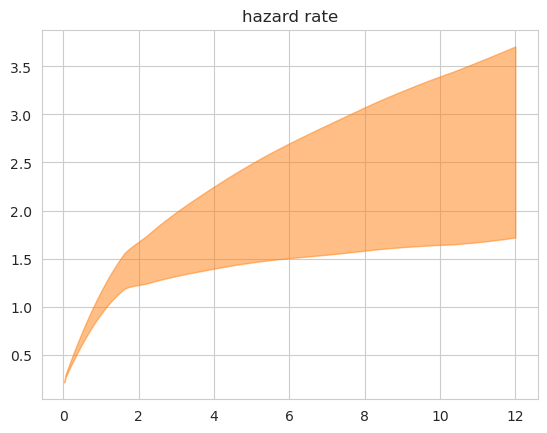

In [224]:
ax = pm.plots.plot_hdi(pred["survival"].time, pred["hazard"])
ax.set_title("hazard rate");

In [256]:
time = np.linspace(0, 12, 12*2+1)
test_t = [0, 1, 2, 3]
with pm.Model(coords={"time": time, "time2": time}) as pred_model:
    lam = pm.Flat("lam")
    alpha = pm.Flat("alpha")
    for t in test_t:
        pm.Deterministic(
            f"conditional_survival_{t}",
            # pt.exp(pm.logcdf(pm.Weibull.dist(alpha=alpha, beta=lam), time)),
            pt.exp(pm.logcdf(pm.Truncated.dist(pm.Weibull.dist(alpha=alpha, beta=lam), lower=t+1e-8), time)),
            dims=("time"),
        )
    
    pred = pm.compute_deterministics(weibull_idata.posterior)

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

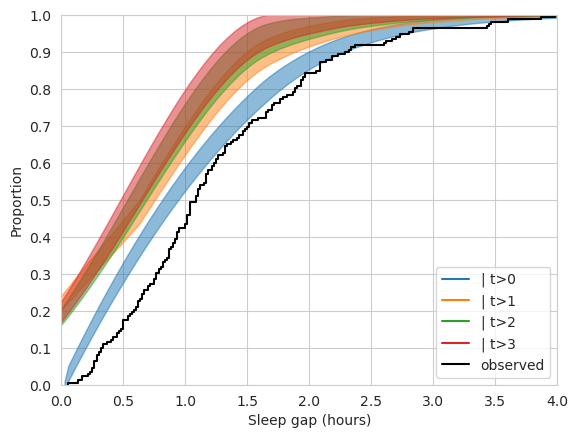

In [260]:
for i, t in enumerate(test_t):
    c = f"C{i}"
    ax = pm.plots.plot_hdi(pred.time - t, pred[f"conditional_survival_{t}"], color=c)
    ax.plot([], color=c, label=f"| t>{t}")
ax = sns.ecdfplot(sdf["sleep_gap"].dt.seconds / 60 / 60, color="k", label="observed")
# ax.set_title("Accelerated failure (Weibull model)")
ax.set_xlabel("Sleep gap (hours)")
ax.set_ylim(0, 1)
ax.set_xlim(0, 4)
ax.set_yticks(np.linspace(0, 1, 11))
plt.legend();